In [96]:
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.stats import zscore, mannwhitneyu

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=11)
    ax.yaxis.set_tick_params(labelsize=11)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.7)
    return True

In [11]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

gene_tss_info = {'positive': {}, 'negative': {}}
for chrom in chroms:
    gene_tss_info['positive'][chrom] = []
    gene_tss_info['negative'][chrom] = []
    with open('../data/annotation/chrom_wise_gencode_tss/%s.bed' % chrom) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            up = int(c[1]) - 1000
            down = int(c[1]) + 1000 + 1
            if c[5] == '+':
                gene_tss_info['positive'][chrom].append((up, down, c[3]))
            else:
                gene_tss_info['negative'][chrom].append((up, down, c[3]))

In [15]:
gene_phastcons = []
for chrom in chroms:
    phastcons = np.load('../data/phastcons/chrom_arrays/%s.npy' % chrom, mmap_mode='r')
    for i in tqdm(gene_tss_info['positive'][chrom], desc=chrom):
        gene_phastcons.append(phastcons[i[0]:i[1]])
    for i in tqdm(gene_tss_info['negative'][chrom], desc=chrom):
        gene_phastcons.append(phastcons[i[0]:i[1]][::-1])
    clear_output()
np.save('../data/gene_arrays/gene_phastcons', np.array(gene_phastcons))

In [16]:
# gene array for exp scores was creaed in promoter_analysis notebook

gene_array_exp = {}
for orient in ['sense', 'antisense']:
    gene_array_exp[orient] = np.load('../data/gene_arrays/exp_scores_%s.npy' % orient)
gene_phastcons = np.load('../data/gene_arrays/gene_phastcons.npy')

In [34]:
mean_exp_sense = gene_array_exp['sense'].mean(axis=0)
mean_exp_antisense = gene_array_exp['antisense'].mean(axis=0)
mean_phastcons = gene_phastcons.mean(axis=0)

z_exp_sense = zscore(mean_exp_sense)
z_exp_antisense = zscore(mean_exp_antisense)
z_phastcons = zscore(mean_phastcons)

In [ ]:
top_quantile = []
bottom_quantile = []
for i,j in tqdm(zip(gene_phastcons, gene_array_exp['antisense'])):
    top_quantile.append(j[:1000][i[:1000].argsort()[:100]])
    bottom_quantile.append(j[:1000][i[:1000].argsort()[-100:]])
top_quantile = np.array(top_quantile)
bottom_quantile = np.array(bottom_quantile)

a = sorted(top_quantile.max(axis=1))[::-1][:int(top_quantile.shape[0]/10)]
b = sorted(bottom_quantile.max(axis=1))[::-1][:int(bottom_quantile.shape[0]/10)]
len(a), len(b)

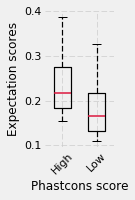

MannwhitneyuResult(statistic=119745579.5, pvalue=0.0)

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3))

boxprops = dict(linestyle='-', linewidth=1.2, color='k')
whiskerprops = dict(linestyle='--', linewidth=1.2, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([a, b], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel('Expectation scores', fontsize=12)
ax.set_xticklabels(['High', 'Low'], rotation=45, fontsize=11)
ax.set_xlabel('Phastcons score', fontsize=12)
clean_axis(ax)

plt.tight_layout()
plt.show()

plt.savefig('../images/phastcons_promoter.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/phastcons_promoter.svg', transparent=True, edgecolor='none')

mannwhitneyu(a, b)